In [23]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, lit, to_date, split, when, coalesce, unix_timestamp, monotonically_increasing_id, avg, round, expr
from pyspark.sql.types import MapType, StringType
from pyspark.sql.window import Window

In [2]:
spark = SparkSession.builder \
                    .appName('tennis') \
                    .getOrCreate()

# Singles

In [3]:
singles=spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')

singles.show(2)

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+--------------+-----------+---------+----------+----------+--------+----------+-----------+-------------+----------+--------+---------+---------+-----------+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|   winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|   loser_name|loser_hand|loser_ht|loser_ioc|loser_age|      score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+-

In [4]:
from pyspark.sql.functions import col, count, round

singles = singles.withColumn('winner_entry', when(singles['winner_entry'].isNull(), "Standard").otherwise(singles['winner_entry']))
singles = singles.withColumn('loser_entry', when(singles['loser_entry'].isNull(), "Standard").otherwise(singles['loser_entry']))

null_counts = singles.select([round(((count(when(col(c).isNull(), c)) / singles.count()) * 100), 1).alias(c) for c in singles.columns])
null_counts.show()

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+-----------+-----------+---------+----------+----------+--------+----------+-----------+----------+----------+--------+---------+---------+-----+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|loser_name|loser_hand|loser_ht|loser_ioc|loser_age|score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+----------+------------+-

In [5]:
selected_columns = ['surface',
                    'tourney_level',
                    'tourney_name',
                    'draw_size',
                    'winner_name',
                    'winner_hand', 
                    'winner_ht',
                    'winner_ioc',
                    'winner_age',
                    'loser_name',
                    'loser_hand',
                    'loser_ht',
                    'loser_ioc',
                    'winner_entry',
                    'loser_entry',
                    'loser_age',
                    'best_of',
                    'round',
                    'winner_rank',
                    'loser_rank'
                   ]

clean_df = singles.select(selected_columns)
clean_df = clean_df.filter(clean_df['best_of'] != 1)
clean_df = clean_df.dropna()
clean_df.show(2)

+-------+-------------+------------+---------+-------------+-----------+---------+----------+----------+-------------+----------+--------+---------+------------+-----------+---------+-------+-----+-----------+----------+
|surface|tourney_level|tourney_name|draw_size|  winner_name|winner_hand|winner_ht|winner_ioc|winner_age|   loser_name|loser_hand|loser_ht|loser_ioc|winner_entry|loser_entry|loser_age|best_of|round|winner_rank|loser_rank|
+-------+-------------+------------+---------+-------------+-----------+---------+----------+----------+-------------+----------+--------+---------+------------+-----------+---------+-------+-----+-----------+----------+
|   Hard|            A|    Adelaide|       32|Thomas Muster|          L|      180|       AUT|      26.2|Bryan Shelton|         R|     185|      USA|    Standard|   Standard|     28.0|      3|  R32|          9|        97|
|   Hard|            A|    Adelaide|       32| Brett Steven|          R|      185|       NZL|      24.6|  Byron Blac

In [6]:
clean_df.dtypes

[('surface', 'string'),
 ('tourney_level', 'string'),
 ('tourney_name', 'string'),
 ('draw_size', 'int'),
 ('winner_name', 'string'),
 ('winner_hand', 'string'),
 ('winner_ht', 'int'),
 ('winner_ioc', 'string'),
 ('winner_age', 'double'),
 ('loser_name', 'string'),
 ('loser_hand', 'string'),
 ('loser_ht', 'int'),
 ('loser_ioc', 'string'),
 ('winner_entry', 'string'),
 ('loser_entry', 'string'),
 ('loser_age', 'double'),
 ('best_of', 'int'),
 ('round', 'string'),
 ('winner_rank', 'int'),
 ('loser_rank', 'int')]

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
import scipy.stats as stats
import pandas as pd
from sklearn import preprocessing

df = clean_df.toPandas()
le = preprocessing.LabelEncoder()
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [8]:
correlation_matrix_list = []

for a in clean_df.dtypes:
    print(a)
    correlation_list = []

    for b in clean_df.dtypes:
        #print(b)
        
        if a[1] == b[1] and a[1] == 'string':
            confusion_matrix = pd.crosstab(df[a[0]], df[b[0]])
            correlacao = cramers_v(confusion_matrix.values)
                            
        if a[1] == b[1] and a[1] == 'int':
            #features = [a[0], b[0]]  # List of column names
            correlacao = df[a[0]].corr(df[b[0]])

        if a[1] != b[1]:
            df[a[0]] = le.fit_transform(df[a[0]])
            df[b[0]]= le.fit_transform(df[b[0]])

            correlacao = stats.pointbiserialr(df[a[0]], df[b[0]])[0]
        
        correlation_list.append(correlacao)

    correlation_matrix_list.append(correlation_list)

('surface', 'string')
('tourney_level', 'string')
('tourney_name', 'string')
('draw_size', 'int')
('winner_name', 'string')
('winner_hand', 'string')
('winner_ht', 'int')
('winner_ioc', 'string')
('winner_age', 'double')
('loser_name', 'string')
('loser_hand', 'string')
('loser_ht', 'int')
('loser_ioc', 'string')
('winner_entry', 'string')
('loser_entry', 'string')
('loser_age', 'double')
('best_of', 'int')
('round', 'string')
('winner_rank', 'int')
('loser_rank', 'int')


We calculated diferent correlation tests depending on the variable

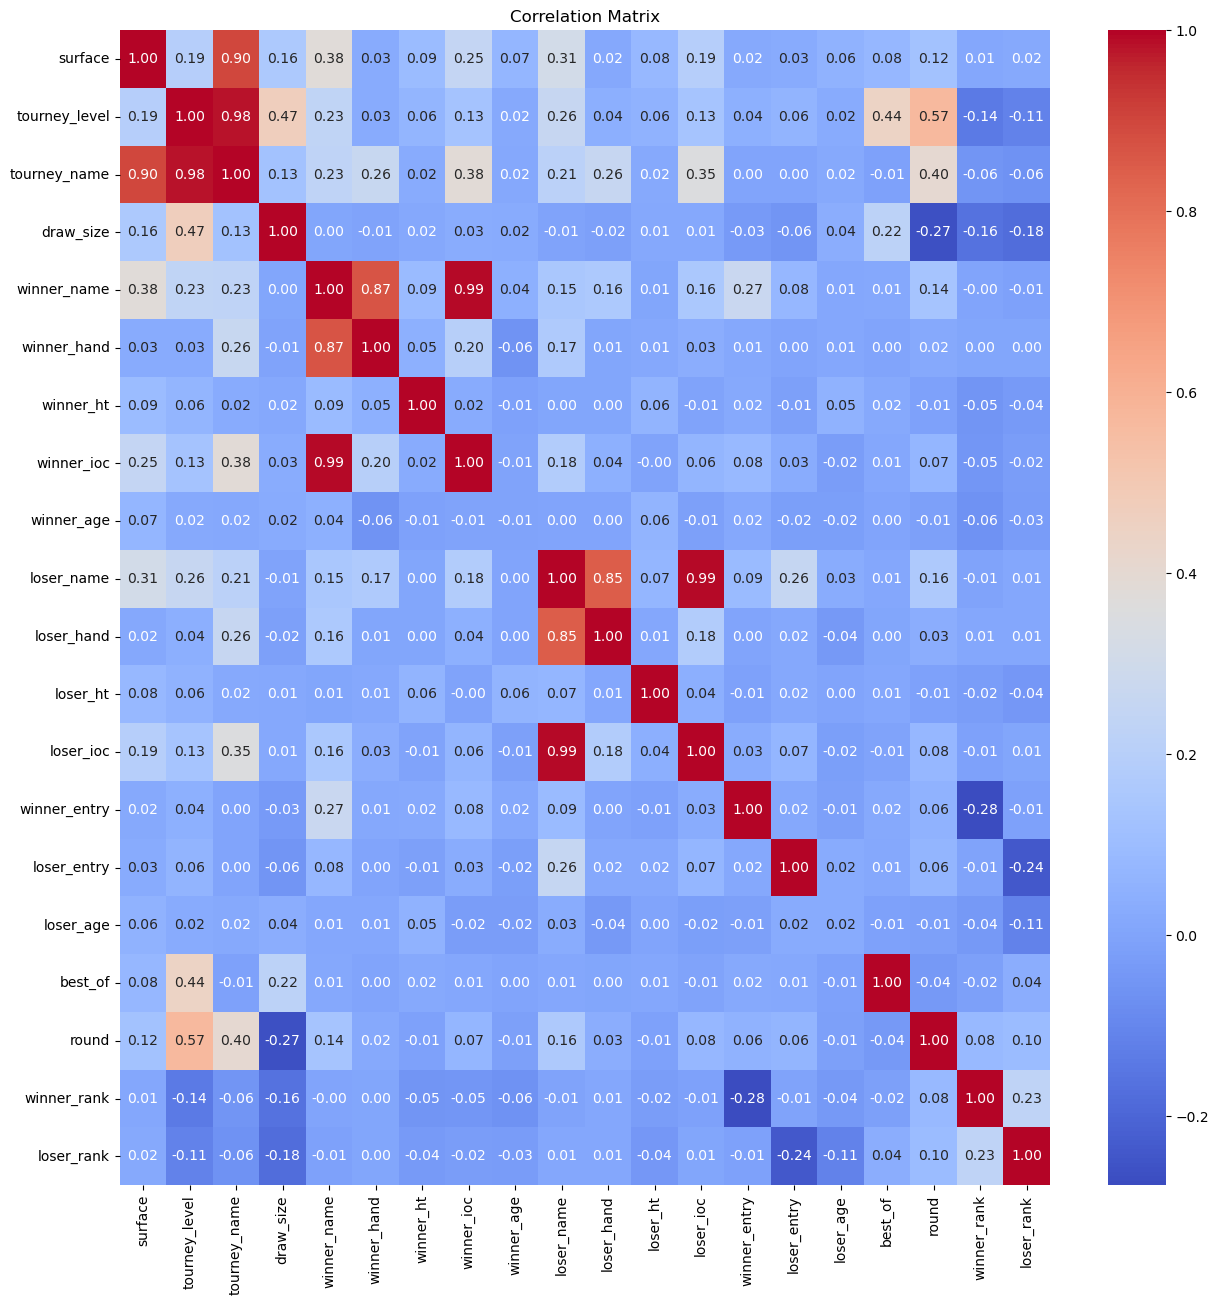

In [9]:
#Correlation matrix for ML features

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

column_names = clean_df.columns

correlation_matrix_array = np.array(correlation_matrix_list)

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_array, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=90)
plt.yticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=0)
plt.show()

In [10]:
def show(df):
    """function for easy visualization of tables"""
    pandas_df = df.toPandas()
    return pandas_df

In [11]:
# Selecting relevant columns for feature engineering
selected_columns = ['surface',
                    'tourney_level',
                    'tourney_date',
                    'tourney_name',
                    'draw_size',
                    'round',
                    'best_of',
                    'winner_name',
                    'winner_hand',
                    'winner_rank',
                    'winner_ht',
                    'winner_ioc',
                    'winner_age',
                    'winner_entry',
                    'loser_name',
                    'loser_hand',
                    'loser_rank',
                    'loser_ht',
                    'loser_ioc',
                    'loser_age',
                    'loser_entry',
                    'w_ace',
                    'w_df',
                    'w_svpt',
                    'w_1stIn',
                    'w_1stWon',
                    'w_2ndWon',
                    'w_SvGms',
                    'l_ace',
                    'l_df',
                    'l_svpt',
                    'l_1stIn',
                    'l_1stWon',
                    'l_2ndWon',
                    'l_SvGms'
                   ]

# Filtering relevant columns
clean_df = singles.select(selected_columns)

# Kepping only Bo3 and Bo5 matches
clean_df = clean_df.filter(clean_df['best_of'] != 1)

# Removing Nulls
clean_df = clean_df.dropna()

# Changing date format 
clean_df = clean_df.withColumn('tourney_date', to_date(clean_df['tourney_date'].cast('string'), 'yyyyMMdd'))

show(clean_df)

,surface,tourney_level,tourney_date,tourney_name,draw_size,round,best_of,winner_name,winner_hand,winner_rank,...,w_1stWon,w_2ndWon,w_SvGms,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms
0,Hard,A,1994-01-03,Adelaide,32,R32,3,Thomas Muster,L,9,...,21,13,8,6,6,64,30,17,15,8
1,Hard,A,1994-01-03,Adelaide,32,R32,3,Brett Steven,R,43,...,29,8,9,0,4,55,34,21,6,8
2,Hard,A,1994-01-03,Adelaide,32,R32,3,Karel Novacek,R,17,...,31,10,9,1,5,63,35,24,12,9
3,Hard,A,1994-01-03,Adelaide,32,R32,3,Jamie Morgan,R,64,...,38,24,16,2,5,99,52,32,21,15
4,Hard,A,1994-01-03,Adelaide,32,R32,3,David Rikl,L,95,...,27,11,10,2,2,74,48,29,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92799,Hard,A,2020-10-19,Antwerp,32,R32,3,Daniel Evans,R,35,...,36,14,13,4,1,77,43,31,14,13
92800,Hard,A,2020-10-19,Antwerp,32,R32,3,Zizou Bergs,R,528,...,33,13,12,1,3,66,45,27,10,12
92801,Hard,A,2020-10-19,Antwerp,32,R32,3,Taylor Fritz,R,28,...,39,6,10,19,3,58,37,30,5,9
92802,Hard,A,2020-10-19,Antwerp,32,R32,3,Lloyd Harris,R,90,...,28,11,10,0,2,62,45,29,5,10


In [12]:
print(f'Number of rows: {clean_df.count()}')
print(f'Number of columns: {len(clean_df.columns)}')

Number of rows: 92804
Number of columns: 35


#### The following cell is responsible for randomly split the column of player 1 on order to the player 1 not be always the winner and not create bias on the training sample

In [13]:
# Creating Label column. 1 if the first player won, 0 if the second player won.
clean_df = clean_df.withColumn("Winner", lit(1))

## Randomizing player 1 and 2 so that the label isn't always 1

# Dividing into two df randomly
split_1, split_2 = clean_df.randomSplit([0.5, 0.5], seed=10)

# Changing column order for split 2
split_2_order = ['surface',
                'tourney_level',
                'tourney_date',
                'tourney_name',
                'draw_size',
                'round',
                'best_of',
                'loser_name',
                'loser_hand',
                'loser_rank',
                'loser_ht',
                'loser_ioc',
                'loser_age',
                'loser_entry',
                'winner_name',
                'winner_hand',
                'winner_rank',
                'winner_ht',
                'winner_ioc',
                'winner_age',
                'winner_entry',
                'l_ace',
                'l_df',
                'l_svpt',
                'l_1stIn',
                'l_1stWon',
                'l_2ndWon',
                'l_SvGms',
                'w_ace',
                'w_df',
                'w_svpt',
                'w_1stIn',
                'w_1stWon',
                'w_2ndWon',
                'w_SvGms'
               ]
split_2 = split_2.select(split_2_order)

# Reverting the name change (at this point the names are wrong. The winner_name will be the name of the loser actually, etc.)
old_names = ['loser_name', 'loser_hand', 'loser_rank', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_entry',
             'winner_name', 'winner_hand', 'winner_rank', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_entry',
             'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
             'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms']

new_names = ['winner_name', 'winner_hand', 'winner_rank', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_entry',
             'loser_name', 'loser_hand', 'loser_rank', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_entry',
             'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
             'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms']

# Adjusting label to be 0
split_2 = split_2.withColumn("Winner", lit(0))

# Merging them back together
clean_df = split_1.union(split_2)

In [14]:
# Changing column names from winner/loser to player 1/player 2
old_names = ['winner_name', 'winner_hand', 'winner_rank', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_entry',
             'loser_name', 'loser_hand', 'loser_rank', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_entry',
             'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
             'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms']

new_names = ['p1_name', 'p1_hand', 'p1_rank', 'p1_ht', 'p1_ioc', 'p1_age', 'p1_entry',
             'p2_name', 'p2_hand', 'p2_rank', 'p2_ht', 'p2_ioc', 'p2_age', 'p2_entry',
             'p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn', 'p1_1stWon', 'p1_2ndWon', 'p1_SvGms',
             'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn', 'p2_1stWon', 'p2_2ndWon', 'p2_SvGms']

for old_name, new_name in zip(old_names, new_names):
    clean_df = clean_df.withColumnRenamed(old_name, new_name)

In [15]:
## Creating columns for % or 1st serve and 2nd serve points won
# Player 1, 1st and 2nd serve
clean_df = clean_df.withColumn('p1_1stW', col('p1_1stWon')/col('p1_1stIn'))
clean_df = clean_df.withColumn('p1_2ndW', 'p1_2ndWon'/(col('p1_svpt') - col('p1_1stIn') - col('p1_df'))) # Serve points - 1st serve in - double faults = 2nd serve in

# Player 2, 1st and 2nd serve
clean_df = clean_df.withColumn('p2_1stW', col('p2_1stWon')/col('p2_1stIn'))
clean_df = clean_df.withColumn('p2_2ndW', col('p2_2ndWon')/(col('p2_svpt') - col('p2_1stIn') - col('p2_df'))) # Serve points - 1st serve in - double faults = 2nd serve in

In [24]:
## CALCULATING PLAYER STATISTICS FOR THE PAST 3 MONTHS
# Creating an id for each match
clean_df = clean_df.withColumn("match_id", monotonically_increasing_id())

# creating an auxiliary df to hold the information for each player in one column
df1 = clean_df.select(['match_id', 'tourney_date', 'p1_name', 'p1_ace', 'p1_df', 'p1_1stW', 'p1_2ndW'])
df2 = clean_df.select(['match_id', 'tourney_date', 'p2_name', 'p2_ace', 'p2_df', 'p2_1stW', 'p2_2ndW'])
aux_df = df1.union(df2)
aux_df = aux_df.withColumnRenamed('p1_name', 'p_name')
aux_df = aux_df.withColumnRenamed('p1_ace', 'p_ace')
aux_df = aux_df.withColumnRenamed('p1_df', 'p_df')
aux_df = aux_df.withColumnRenamed('p1_1stW', 'p_1stW')
aux_df = aux_df.withColumnRenamed('p1_2ndW', 'p_2ndW')

# Creating Unix timestamp column based on tourney_date to help below
aux_df = aux_df.withColumn('tourney_date_unix', unix_timestamp(col('tourney_date')))

# Defining sliding window for the previoues 90 days of each player
windowSpec = Window.partitionBy(['p_name']).orderBy('tourney_date_unix').rangeBetween(-90 * 24 * 60 * 60, -1)

# Creating a new column that gets the average statistic for each player over the window
aux_df = aux_df.withColumn('avg_p_ace', avg('p_ace').over(windowSpec))
aux_df = aux_df.withColumn('avg_p_df', avg('p_df').over(windowSpec))
aux_df = aux_df.withColumn('avg_p_1stW', avg('p_1stW').over(windowSpec))
aux_df = aux_df.withColumn('avg_p_2ndW', avg('p_2ndW').over(windowSpec))

In [25]:
# Changing the names of columns to avoid conflicts when joining
old_names = aux_df.columns
new_names = ['aux_match_id', 'aux_tourney_date', 'aux_p_name', 'aux_p_ace', 'aux_p_df', 'aux_p_1stW', 'aux_p_2ndW', 'aux_tourney_date_unix', 'aux_avg_p_ace', 'aux_avg_p_df', 'aux_avg_p_1stW', 'aux_avg_p_2ndW']
for old_name, new_name in zip(old_names, new_names):
    aux_df = aux_df.withColumnRenamed(old_name, new_name)

# Joining for player 1 
joined_df = clean_df.join(aux_df, (clean_df['match_id'] == aux_df['aux_match_id']) & (clean_df['p1_name'] == aux_df['aux_p_name']), "left_outer")
joined_df = joined_df.withColumnRenamed('aux_avg_p_ace', 'p1_ace_avg')
joined_df = joined_df.withColumnRenamed('aux_avg_p_df', 'p1_df_avg')
joined_df = joined_df.withColumnRenamed('aux_avg_p_1stW', 'p1_1stW_avg')
joined_df = joined_df.withColumnRenamed('aux_avg_p_2ndW', 'p1_2ndW_avg')

# Dropping aux columns
joined_df = joined_df.drop('aux_match_id', 'aux_tourney_date', 'aux_p_name', 'aux_p_ace', 'aux_p_df', 'aux_p_1stW', 'aux_p_2ndW', 'aux_tourney_date_unix')

# Joining for player 2
joined_df = joined_df.join(aux_df, (joined_df['match_id'] == aux_df['aux_match_id']) & (joined_df['p2_name'] == aux_df['aux_p_name']), "left_outer")
joined_df = joined_df.withColumnRenamed('aux_avg_p_ace', 'p2_ace_avg')
joined_df = joined_df.withColumnRenamed('aux_avg_p_df', 'p2_df_avg')
joined_df = joined_df.withColumnRenamed('aux_avg_p_1stW', 'p2_1stW_avg')
joined_df = joined_df.withColumnRenamed('aux_avg_p_2ndW', 'p2_2ndW_avg')

# Dropping aux columns
joined_df = joined_df.drop('match_id', 'aux_match_id', 'aux_tourney_date', 'aux_p_name', 'aux_p_ace', 'aux_p_df', 'aux_p_1stW', 'aux_p_2ndW', 'aux_tourney_date_unix')

In [26]:
final_df = joined_df.select(['surface',
                             'tourney_level',
                             'tourney_name',
                             'draw_size',
                             'round',
                             'best_of',
                             'p1_name',
                             'p1_hand',
                             'p1_rank',
                             'p1_ht',
                             'p1_ioc',
                             'p1_age',
                             'p1_entry',
                             'p2_name',
                             'p2_hand',
                             'p2_rank',
                             'p2_ht',
                             'p2_ioc',
                             'p2_age',
                             'p2_entry',
                             'p1_ace_avg',
                             'p1_df_avg',
                             'p1_1stW_avg',
                             'p1_2ndW_avg',
                             'p2_ace_avg',
                             'p2_df_avg',
                             'p2_1stW_avg',
                             'p2_2ndW_avg',
                             'Winner']
                           )

In [27]:
final_df = final_df.dropna()
show(final_df)

,surface,tourney_level,tourney_name,draw_size,round,best_of,p1_name,p1_hand,p1_rank,p1_ht,...,p2_entry,p1_ace_avg,p1_df_avg,p1_1stW_avg,p1_2ndW_avg,p2_ace_avg,p2_df_avg,p2_1stW_avg,p2_2ndW_avg,Winner
0,Carpet,A,Philadelphia,32,F,3,Mark Woodforde,L,41,188,...,Standard,4.285714,3.857143,0.780988,0.600000,7.400000,2.600000,0.780039,0.469298,1
1,Carpet,A,Rotterdam,32,R16,3,Diego Nargiso,L,107,188,...,Standard,10.200000,5.600000,0.765609,0.568422,10.600000,9.700000,0.807582,0.568603,1
2,Carpet,A,Rotterdam,32,R32,3,Andrei Olhovskiy,R,89,185,...,Standard,6.125000,3.375000,0.737980,0.517627,1.300000,3.000000,0.629091,0.469071,1
3,Carpet,A,Rotterdam,32,R32,3,Omar Camporese,R,71,188,...,Q,5.200000,2.600000,0.759685,0.521352,0.857143,2.142857,0.653064,0.459722,1
4,Carpet,A,Tokyo Indoor,48,R64,3,Jacco Eltingh,R,61,188,...,Standard,6.545455,3.545455,0.678675,0.591692,4.200000,4.000000,0.691941,0.587205,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73214,Hard,G,Australian Open,128,R16,5,Nick Kyrgios,R,26,193,...,Standard,17.833333,2.166667,0.811142,0.655392,6.117647,1.529412,0.791991,0.640178,0
73215,Hard,G,Australian Open,128,R64,5,Kevin Anderson,R,122,203,...,Standard,13.000000,2.666667,0.801824,0.459677,8.375000,2.250000,0.761789,0.638462,0
73216,Hard,G,Us Open,128,R32,5,Casper Ruud,R,37,183,...,Standard,4.000000,1.000000,0.722222,0.483871,11.000000,3.000000,0.828431,0.692073,0
73217,Hard,M,Paris Masters,64,R64,3,Marton Fucsovics,R,52,188,...,Standard,3.636364,3.090909,0.606210,0.575331,6.764706,2.176471,0.726690,0.707798,0


In [29]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import year


# Columns to encode
to_encode = ['surface', 'tourney_level', 'tourney_name', 'round', 
                     'p1_name', 'p1_hand', 'p1_ioc', 'p1_entry', 
                     'p2_name', 'p2_hand', 'p2_ioc', 'p2_entry']



# Create stages for StringIndexer and OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip") for col in to_encode]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in to_encode]

# Combine stages for the pipeline
stages = indexers + encoders

# Create a pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the data
model = pipeline.fit(final_df)
final_df = model.transform(final_df)

# Select relevant features for training
selected_features = [
    'best_of', 'draw_size', 'p1_rank', 'p1_ht', 'p1_age', 'p2_rank', 'p2_ht', 'p2_age',
    'p1_ace_avg', 'p1_df_avg', 'p1_1stW_avg', 'p1_2ndW_avg',
    'p2_ace_avg', 'p2_df_avg', 'p2_1stW_avg', 'p2_2ndW_avg',
    # Include the encoded columns
    'surface_encoded', 'tourney_level_encoded', 'tourney_name_encoded',
    'round_encoded', 'p1_name_encoded', 'p1_hand_encoded', 'p1_ioc_encoded', 'p1_entry_encoded',
    'p2_name_encoded', 'p2_hand_encoded', 'p2_ioc_encoded', 'p2_entry_encoded',
    'Winner'
]

# Select and display the final encoded DataFrame
final_df = final_df.select(selected_features)
show(final_df)

,best_of,draw_size,p1_rank,p1_ht,p1_age,p2_rank,p2_ht,p2_age,p1_ace_avg,p1_df_avg,...,round_encoded,p1_name_encoded,p1_hand_encoded,p1_ioc_encoded,p1_entry_encoded,p2_name_encoded,p2_hand_encoded,p2_ioc_encoded,p2_entry_encoded,Winner
0,3,32,41,188,27.3,9,188,32.9,4.285714,3.857143,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1
1,3,32,107,188,22.9,18,183,24.5,10.200000,5.600000,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1
2,3,32,89,185,26.8,69,180,27.6,6.125000,3.375000,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1
3,3,32,71,188,24.7,78,180,30.6,5.200000,2.600000,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1
4,3,48,61,188,23.1,128,183,23.1,6.545455,3.545455,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73214,5,128,26,193,24.7,1,185,33.6,17.833333,2.166667,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0
73215,5,128,122,203,33.6,34,193,22.2,13.000000,2.666667,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0
73216,5,128,37,183,21.6,8,196,24.3,4.000000,1.000000,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0
73217,3,64,52,188,28.7,24,188,23.9,3.636364,3.090909,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1

In [30]:
final_df.write.mode('overwrite').parquet('final_df_parquet')